# Testing serpent_output_tool package
## Chapeter 0: initializing the package.
In this section, the package will be initialized and some environmental variables will be imported.

In [80]:
import os
import sys
from serpent_output_tools import detector_tools
utilities_path = os.getenv('PYDIR') # IN THIS CASE THE PYTHON PACKAGE STORING ALL THE UTILITIES WAS LOCATED IN THIS DIRECTORY
sys.path.append(utilities_path)
from package_utilities import geometrical_tools, plot_tools


## Chapter 1: Testing detectors with cartesian geometry
In this section the detector with cartesian geometry. 
The file is located in the directory TEST_CART. The file is test_cart_det0.m.
In this test the pin by pin power, the spectra and the fission cross section will be printed.

In [81]:
input_data = {'path':'./TEST_CART',
                 'file':'test_cart_det0.m',
                 'detectors':['power_MOX_FA','spectra_MATERIALS','xsf_MOX1'],
                 'composition':[4.9682E-05,2.1644E-02,4.3144E-04],
                 'mat_merge':['spectra_MATERIALS'],
                 'rch_merge':['xsf_MOX1'],
                 'bin_merge':['spectra_MATERIALS','power_MOX_FA'],
                 'bin_masked_merge':[],
                 'mask':[]}
pin_radius = 0.47400
grod_radius = 0.61300
lat_dim = 17
pitch_pin = 1.262

Extracting data from the detector to prepare a dictionary storing all data.

In [82]:
DRC = detector_tools.DetectorReader(input_data['path']+'/'+input_data['file'], input_data['detectors'])
for det in input_data['detectors']:
    DRC.set_ucs(det)

for det in input_data['detectors']:
    if det in input_data['mat_merge']:
        DRC.tallies_merge(det,['material'])
    if det in input_data['rch_merge']:
        # THIS OPERATION CAN BE USED FOR DPA EVALUATION
        DRC.tallies_merge(det,['reaction'],_composition = input_data['composition'])

for det in input_data['detectors']:
    if det in input_data['bin_merge']:
        DRC.bins_merge(det,['x3']) # < --- AXIAL MERGING, RETURNS THE RADIAL POWER DISTRIBUTION
        DRC.bins_merge(det,['x1','x2']) # < --- RADIAL MERGING, RETURNS THE AXIAL POWER DISTRIBUTION
        DRC.bins_merge(det,['x1','x2','x3']) # < --- AXIAL AND RADIAL MERGING

out_cart = DRC.get_output()

Setting coordinates for detector: power_MOX_FA
Setting coordinates for detector: spectra_MATERIALS
Setting coordinates for detector: xsf_MOX1
Performing uni/cell/mat/rch merge on detector: spectra_MATERIALS...   ... merge type: ['material']
OLD KEYS: dict_keys(['u0_c0_m0_l0_r0', 'u0_c0_m1_l0_r0', 'u0_c0_m2_l0_r0', 'u0_c0_m3_l0_r0', 'u0_c0_m4_l0_r0', 'u0_c0_m5_l0_r0'])
...adding: u0_c0_l0_r0
NEW KEYS: dict_keys(['u0_c0_m0_l0_r0', 'u0_c0_m1_l0_r0', 'u0_c0_m2_l0_r0', 'u0_c0_m3_l0_r0', 'u0_c0_m4_l0_r0', 'u0_c0_m5_l0_r0', 'u0_c0_l0_r0'])
Performing uni/cell/mat/rch merge on detector: xsf_MOX1...   ... merge type: ['reaction']
OLD KEYS: dict_keys(['u0_c0_m0_l0_r0', 'u0_c0_m0_l0_r1', 'u0_c0_m0_l0_r2'])
...adding: u0_c0_m0_l0
NEW KEYS: dict_keys(['u0_c0_m0_l0_r0', 'u0_c0_m0_l0_r1', 'u0_c0_m0_l0_r2', 'u0_c0_m0_l0'])
Performing bin merge on detector: power_MOX_FA...   ... merge type: ['x3']
operazione conclusa...
Performing bin merge on detector: power_MOX_FA...   ... merge type: ['x1', 'x2']
op

Plotting the power distribution.

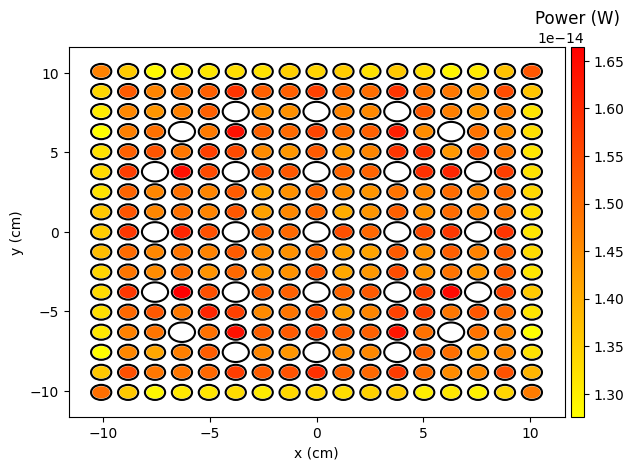

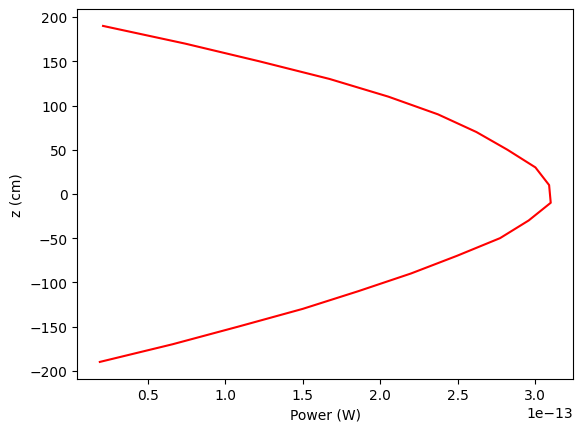

In [83]:
pin_coords = out_cart['power_MOX_FA']['ucs']
axial_power = out_cart['power_MOX_FA']['tallies']['u0_c0_m0_l0_r0']['base_x1x2']['values'][0]
radial_power = out_cart['power_MOX_FA']['tallies']['u0_c0_m0_l0_r0']['base_x3']['values'][0]
LATTICE = geometrical_tools.LatticeEnumeration()
LATTICE.add_dimension(lat_dim,lat_dim)
LATTICE.add_enumeration('alphanum')
lat = LATTICE.get_lattice()

PLOT2D = plot_tools.General2DPlotter()
PLOT2D.add_label('x (cm)','y (cm)')
PG = geometrical_tools.PolygonGenerator()
CGP = geometrical_tools.CircleGenerator()
CGR = geometrical_tools.CircleGenerator()
pin_data = []
for j1 in range(lat_dim):
    for j2 in range(lat_dim):
        square = geometrical_tools.CenterToPolygon.square_generator(pin_coords[j1,j2,0],pitch_pin,'array')
        PG.add_polygon(square)
        if radial_power[j1,j2,0] > 0:
            CGP.add_circle(pin_coords[j1,j2,0],pin_radius)
            pin_data.append(radial_power[j1,j2,0])
        else:
            CGR.add_circle(pin_coords[j1,j2,0],grod_radius)
boundary_patches = PG.return_patches()
rod_patches = CGR.return_patches()  
pin_patches = CGP.return_patches()  
PLOT2D.add_data_patches(pin_patches, pin_data,'Power (W)')
PLOT2D.add_boundary_patches(rod_patches)
PLOT2D.add_boundary_patches(pin_patches) 
PLOT2D.show_plot()

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots()
z_coords = out_cart['power_MOX_FA']['grids']['grid_Z']
ax.plot(axial_power.reshape(np.size(axial_power)),z_coords[:,2],'r-')
ax.set_xlabel('Power (W)')
ax.set_ylabel('z (cm)')
plt.show()


In this section the neutron flux spectra for different materials is plotted.

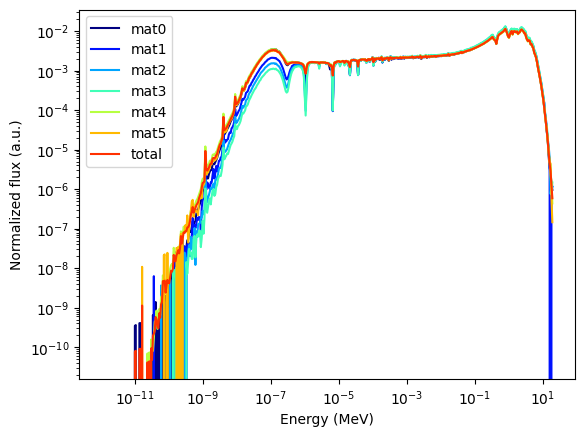

In [84]:
spectra_materials = {}
e_grid = out_cart['spectra_MATERIALS']['grids']['grid_E']

for i in range(out_cart['spectra_MATERIALS']['dim']['material']):
    key_mat = 'mat'+str(i)
    spectrum = []
    for ene in range(out_cart['spectra_MATERIALS']['dim']['energy']):
        spectrum.append(out_cart['spectra_MATERIALS']['tallies']['u0_c0_m'+str(i)+'_l0_r0']['base_x1x2x3']['values'][ene][0,0,0])
    norm_spectrum = np.array([e/sum(spectrum) for e in spectrum])
    spectra_materials[key_mat] = norm_spectrum
total_spectrum = []
for ene in range(out_cart['spectra_MATERIALS']['dim']['energy']):
    total_spectrum.append(out_cart['spectra_MATERIALS']['tallies']['u0_c0_l0_r0']['base_x1x2x3']['values'][ene][0,0,0])
norm_total_spectrum = np.array([e/sum(total_spectrum) for e in total_spectrum])
spectra_materials['total'] = norm_total_spectrum

figs, axs = plt.subplots()
axs.set_xlabel('Energy (MeV)')
axs.set_ylabel('Normalized flux (a.u.)')
axs.set_xscale('log')
axs.set_yscale('log')
palette = matplotlib.colormaps['jet']
total_colors = len(spectra_materials)
counter_color = 0
for key, res in spectra_materials.items():
    axs.plot(e_grid[:,2],res,label = key, color = palette(counter_color/total_colors))
    counter_color += 1
plt.legend()
plt.show()

In this section the fission cross section will be printed.

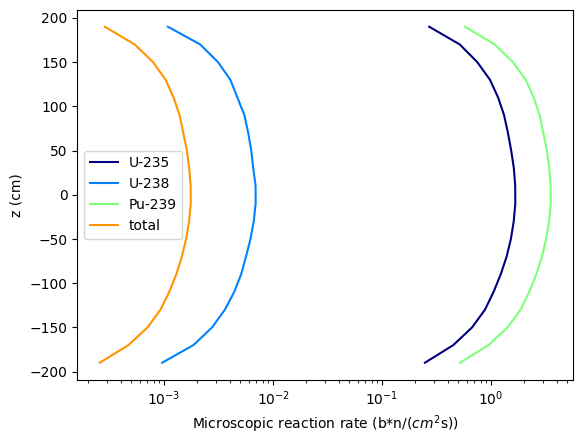

In [85]:
fission_xs = {}
for rch in range(out_cart['xsf_MOX1']['dim']['reaction']):
    match rch:
        case 0:
            key_rch = 'U-235'
        case 1:
            key_rch = 'U-238'
        case 2:
            key_rch = 'Pu-239'
    xs = out_cart['xsf_MOX1']['tallies']['u0_c0_m0_l0_r'+str(rch)]['base']['values'][0]
    xs = xs.reshape(np.size(xs))
    fission_xs[key_rch] = xs
total_xs = out_cart['xsf_MOX1']['tallies']['u0_c0_m0_l0']['base']['values'][0]
total_xs = total_xs.reshape(np.size(total_xs))
fission_xs['total'] = total_xs
figxs, axxs = plt.subplots()
axxs.set_xlabel(r'Microscopic reaction rate (b*n/($cm^{2}$s))')
axxs.set_ylabel('z (cm)')
axxs.set_xscale('log')
counter_color = 0
for keyr, resr in fission_xs.items():
    axxs.plot(resr,z_coords[:,2],color = palette(counter_color/4), label = keyr)
    counter_color += 1
plt.legend()
plt.show()   
    
    
    

Ending of the test with cartesian geometry. The test with hexagonal geometry is a WIP.